In [1]:
# %load tfim1d.py
"""
Test Lindblad based method for ground state preparation for TFIM.

"""

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spinless_fermion_basis_1d

import numpy as np # generic math functions
import scipy.linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as la
from qutip import Qobj, mesolve
from TensorizedPauliDecomposition import PauliDecomposition

from lindblad import Lindblad


if __name__ == "__main__":
    ###### define model parameters ######
    L = 4  # number of sites for spin 1
    #
    J = 1.0  # hopping matrix element
    U = 2.0  # onsite interaction
    mu = 0.5  # chemical potential
    #
    basis = spinless_fermion_basis_1d(L)
    #
    ###### setting up hamiltonian ######
    # setting up site-coupling lists
    hopping_left = [[-J, i, i+1] for i in range(L-1)]
    hopping_right = [[+J, i, i+1] for i in range(L-1)]
    potential = [[-mu, i] for i in range(L)]
    interaction = [[U, i, i+1] for i in range(L-1)]
    #
    static = [
        ["+-", hopping_left],
        ["-+", hopping_right],
        ["n", potential],
        ["nn", interaction],
    ]
    # build hamiltonian
    H = hamiltonian(static, [], basis=basis, dtype=np.float64)
    #dynamic terms are empty
    dynamic = []
    #Construct Hamiltonian
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
    #Find ground state
    E_GS,psi_GS = H.eigsh(k=1,which="SA")
    psi_GS = psi_GS.flatten()
    #Transform from sparse matrix to dense matrix
    H_mat = np.array(H.todense())
    #define intereacting A
    gamma=0.1
    K_A=4
    annihilation=np.sqrt(gamma)*np.array([[0,1],[0,0]])
    A_mat=np.zeros((2**L,2**L,K_A),dtype=complex)
    A_mat[:,:,0]=np.kron(annihilation,np.identity(8))
    A_mat[:,:,1]=np.kron(np.kron(np.identity(2),annihilation),np.identity(4))
    A_mat[:,:,2]=np.kron(np.kron(np.identity(4),annihilation),np.identity(2))
    A_mat[:,:,3]=np.kron(np.identity(8),annihilation)


    lb = Lindblad(H_mat,A_mat)
    
    psi0 = psi_GS
    #print('psi0',psi0)  
    
    T = 1
    K = 7
    num_t_1=np.zeros(K)
    rho_error_first=np.zeros(K)
    rho_error_second=np.zeros(K)
    rho_error_third=np.zeros(K)
    result = lb.Lindblad_exact(T, (2**(1+K)), psi0)
    for n in range(K):
        num_t_1[n] = T*(2**(1+n))
        num_t=int(num_t_1[n])
        times = np.arange(num_t+1) * (T/num_t)
        print('Time step=',T/num_t)

        rho_first, H_first=lb.Lindblad_H(T, num_t, psi0,1)
        #pauli1, coeffs1 = PauliDecomposition(H_first)
        # with open("First_order.txt", "w") as f:
        #     for a, b in zip(pauli1, coeffs1):
        #         f.write(f"{b}, {a}\n")
        #print('First order:')
        #print('Corresponding Pauli decomposition:',pauli1)
        #print('Corresponding Coefficients:',coeffs1)

        rho_second, H_second=lb.Lindblad_H(T, num_t, psi0,2)
        #pauli2, coeffs2 = PauliDecomposition(H_second)
        # print('Second order:')
        # print('Corresponding Pauli decomposition:',pauli2)
        # print('Corresponding Coefficients:',coeffs2)

        rho_third, H_third=lb.Lindblad_H(T, num_t, psi0,3)
        #pauli3, coeffs3 = PauliDecomposition(H_third)
        # print('Third order:')
        # print('Corresponding Pauli decomposition:',pauli3)
        # print('Corresponding Coefficients:',coeffs3)

        rho_error_first[n]=la.norm(result[:,:,len(result[0,0,:])-1]-rho_first[:,:,int(num_t)], 'nuc')
        rho_error_second[n]=la.norm(result[:,:,len(result[0,0,:])-1]-rho_second[:,:,int(num_t)], 'nuc')
        rho_error_third[n]=la.norm(result[:,:,len(result[0,0,:])-1]-rho_third[:,:,int(num_t)], 'nuc')

Hermiticity check passed!
Symmetry checks passed!
Time step= 0.5
Time step= 0.25
Time step= 0.125
Time step= 0.0625
Time step= 0.03125
Time step= 0.015625
Time step= 0.0078125


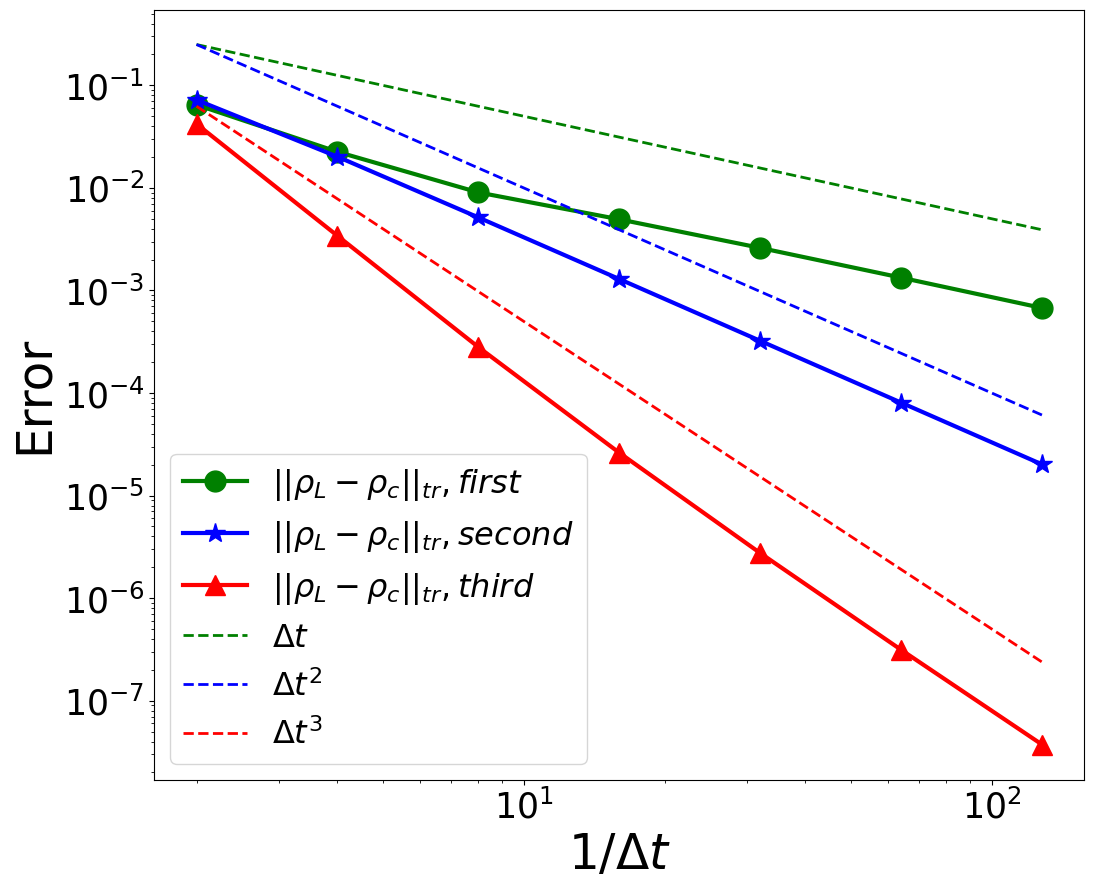

In [2]:
# Error checking (Exact vs coherent)
plt.figure(figsize=(12,10))
plt.plot(num_t_1/T, np.abs(rho_error_first), 'g-o', label=r'$||\rho_L-\rho_c||_{tr},first$', linewidth=3,markersize=15)
plt.plot(num_t_1/T, np.abs(rho_error_second), 'b-*', label=r'$||\rho_L-\rho_c||_{tr},second$', linewidth=3,markersize=15)
plt.plot(num_t_1/T, np.abs(rho_error_third), 'r-^', label=r'$||\rho_L-\rho_c||_{tr},third$', linewidth=3,markersize=15)
# plt.plot(num_t_1/T, np.abs(rho_error_SDE), 'y-o', label=r'$||\rho_L-\rho_c||_{tr},SDE$', linewidth=3,markersize=10)
plt.plot(num_t_1/T, 0.5/(num_t_1), 'g--', label=r'$\Delta t$', linewidth=2)
plt.plot(num_t_1/T, 1/(num_t_1)**2, 'b--', label=r'$\Delta t^{2}$', linewidth=2)
plt.plot(num_t_1/T, 0.5/(num_t_1)**3, 'r--', label=r'$\Delta t^{3}$', linewidth=2)
plt.legend()
plt.xlabel(r'$1/\Delta t$',fontsize=35)
plt.ylabel('Error',fontsize=35)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=23)
plt.savefig('Error_compare_Hubbard_1D.pdf')
plt.show()

In [3]:
#check overlap
#lb = Lindblad(H_mat,A_mat)
# fix the random seed
vt = np.random.randn(lb.Ns)+1j*np.random.randn(lb.Ns)
psi0 = psi_GS
# arbitrary initial condition
#     psi0 = vt.copy()
#     psi0 = psi0 / la.norm(psi0)
T = 5
num_t=25
overlap_exact=np.zeros(num_t)
overlap_first=np.zeros(num_t)
overlap_second=np.zeros(num_t)
overlap_third=np.zeros(num_t)
result = lb.Lindblad_exact(T, num_t, psi0)
times = np.arange(num_t) * (T/num_t)
# print('Time step=',T/num_t)
rho_first, H_1=lb.Lindblad_H(T, num_t, psi0,1)
pauli1, coeffs1 = PauliDecomposition(H_1)
with open("First_order.txt", "w") as f:
            for a, b in zip(pauli1, coeffs1):
                f.write(f"{b}, {a}\n")
# print('First order:')
# print('Corresponding Pauli decomposition:',pauli1)
# print('Corresponding Coefficients:',coeffs1)
rho_second, H_2=lb.Lindblad_H(T, num_t, psi0,2)
pauli2, coeffs2 = PauliDecomposition(H_2)
with open("Second_order.txt", "w") as f:
            for a, b in zip(pauli2, coeffs2):
                f.write(f"{b}, {a}\n")
# print('Second order:')
# print('Corresponding Pauli decomposition:',pauli2)
# print('Corresponding Coefficients:',coeffs2)
rho_third, H_3=lb.Lindblad_H(T, num_t, psi0,3)
pauli3, coeffs3 = PauliDecomposition(H_3)
with open("Third_order.txt", "w") as f:
            for a, b in zip(pauli3, coeffs3):
                f.write(f"{b}, {a}\n")
# print('Third order:')
# print('Corresponding Pauli decomposition:',pauli3)
# print('Corresponding Coefficients:',coeffs3)
for n in range(num_t):
    overlap_first[n]=psi0.conj()@rho_first[:,:,n]@ psi0
    overlap_second[n]=psi0.conj()@rho_second[:,:,n]@ psi0
    overlap_third[n]=psi0.conj()@rho_third[:,:,n]@ psi0

C:\Users\b5172\AppData\Local\Temp\ipykernel_13172\3472153900.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_first[n]=psi0.conj()@rho_first[:,:,n]@ psi0
C:\Users\b5172\AppData\Local\Temp\ipykernel_13172\3472153900.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_second[n]=psi0.conj()@rho_second[:,:,n]@ psi0
C:\Users\b5172\AppData\Local\Temp\ipykernel_13172\3472153900.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_third[n]=psi0.conj()@rho_third[:,:,n]@ psi0


C:\Users\b5172\AppData\Local\Temp\ipykernel_32396\1574645671.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_exact[n]=psi0.conj()@result[:,:,10*n]@ psi0


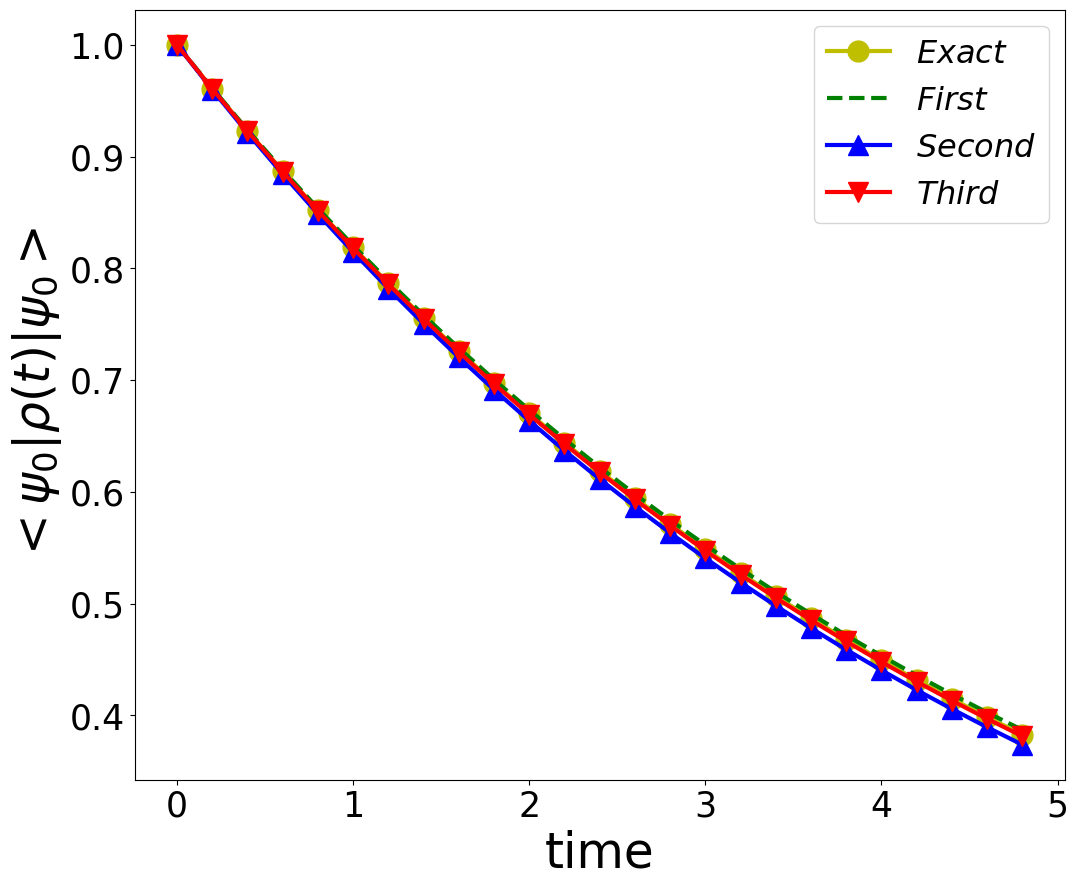

In [13]:
for n in range(num_t):
    overlap_exact[n]=psi0.conj()@result[:,:,10*n]@ psi0
# Error checking (Exact vs coherent)
times = np.arange(num_t) * (T/num_t)
plt.figure(figsize=(12,10))
plt.plot(times, np.abs(overlap_exact), 'y-o', label=r'$Exact$', linewidth=3,markersize=15)
plt.plot(times, np.abs(overlap_first), 'g--', label=r'$First$', linewidth=3,markersize=15)
plt.plot(times, np.abs(overlap_second), 'b-^', label=r'$Second$', linewidth=3,markersize=15)
plt.plot(times, np.abs(overlap_third), 'r-v', label=r'$Third$', linewidth=3,markersize=15)
plt.legend()
plt.xlabel(r'time',fontsize=35)
plt.ylabel(r'$<\psi_0|\rho(t)|\psi_0>$',fontsize=35)
# plt.yscale("log")
# plt.xscale("log")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=23)
plt.savefig('Overlap_compare_Number_T=5.pdf')
plt.show()